In [1]:
import numpy as np

def forcing_to_conc(RF_in, 
                   RF_ext = None, 
                   RF_ext_in = False,
                   param_array = np.array([5.396,278.])):
    
   # --- PARAMETERS ---
    #param_array,
        # 1) a = logarithmic forcing efficacy in W/m-2/alog(2). Default = 5.396 W/m^2
        # 2) Cpreind = preindustrial CO2 concentration in ppmv (278.)
    # RF_ext = external radaitive forcing profile which contributes but shouldn't add to the equivalent CO2 concentrations
    # RE_ext_in = boolean, allows user to include or not include the contribution to RF of other (non-anthropogenic) sources
   #---  ----  ---  ---
    
   #Initializing parameters
    a = param_array[...,0]
    C_preind = param_array[...,1]
    if RF_in.ndim == 1:
        rf_dim = 1
        RF_in = RF_in[np.newaxis]
    else:
        rf_dim = RF_in.shape[0]
    
   # Initializing arrays
    # Create array to hold concentration values
    C = np.zeros((RF_in.shape[0],a.size, RF_in.shape[-1]))
    
    # Check inputs are of the same size if external forcing data is also provided
    if RF_ext_in == True:
        if RF_in.shape != RF_ext.shape:
            print 'The inputs RF_in and RF_ext are not of the same shape!'
    elif RF_ext_in == False:
        RF_ext = np.zeros(RF_in.shape)
    
   # Compute required co2 concentration to produce inputted logarithmic forcing
    for i in range(0, RF_in.shape[-1]):
        C[...,i]=np.exp((RF_in[:,np.newaxis,i]-RF_ext[:,np.newaxis,i])/a)*C_preind
    
    return C

In [2]:
from scipy.optimize import root
import scipy.ndimage.filters as filters1

def iirf100_interp_funct(alpha,a,tau,targ_iirf100):
    iirf100_arr = alpha*(np.sum(a*tau*(1.0 - np.exp(-100.0/(tau*alpha)))))
    return iirf100_arr   -  targ_iirf100

def conc_to_emissions_multiparam(co2_conc, T_input, 
                      tstep = 1.0,
                      year_smoothing = 5,
                      param_array = np.array([1000000,381.330,34.7850,4.12370,0.21787,0.22896,0.28454,0.26863,0.471,32.40,0.019,4.165,97.,278.,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
                      ):
    if param_array.ndim < 2:
        param_array = param_array[np.newaxis]
    
   #initialize parameters
    t_const = param_array[...,0:4]
    pool_splits = param_array[...,4:8]
    GtC_2_ppmv = param_array[...,8]
    r0=param_array[...,9]
    rC=param_array[...,10]
    rT=param_array[...,11]
    iirf100_max = param_array[...,12]
    Cpreind = param_array[...,13]
    R_i_in=param_array[...,14:18]
    T_j_in=param_array[...,18:20]
    in_state_other = param_array[...,20]
    
   # PARAMETERS #
    # co2_conc = inputted co2 forcing equivalent concentration profile
    # T_input = inputted temperature profile for given concentration profile
    # t_const = time constants for the different carbon pools
    # pool_splits = how a unit mass of carbon is split between the pools
    # r0 = 100-year integrated airborne fraction (iIRF100) in the initial equilibrium climate for an infinintesimal pulse
    # rC = sensitivity of iIRF100 to cumulative land-ocean carbon uptake, in years/GtC
    # rT = temperature sensitivity of iIRF100 in years/K
    # iirf100_max = maximum value of the iIRF100 we can calculate (saturates at this value if found to be above)
    # Cpreind = pre-industrial CO2 concentration
    # tstep = timestep between interations of code. Default = 1 yr, never tried for other
    # in_state = input state of the different vectors being calcualted
     
   #initialize the carbon pools, emissions, accumulated carbon and iIRF100 vectors. 
    #Give an intial guess of alpha for root function to work from.
    integ_len = co2_conc.shape[-1]
    num_forc = co2_conc.shape[0]
    num_param = co2_conc.shape[1]
    
    C_comp = np.zeros((num_forc, num_param, integ_len, 4))
    E = np.zeros((num_forc, num_param, integ_len))
    C_acc = np.zeros((num_forc, num_param, integ_len))
    iirf100 = np.zeros((num_forc, num_param, integ_len))
    alph_t_start = 0.16
    alph_t = np.zeros((num_forc,num_param))
    
    if num_param < 1:
        t_const = param_array[np.newaxis]
        pool_splits = param_array[np.newaxis]
        GtC_2_ppmv = param_array[np.newaxis]
        r0=param_array[np.newaxis]
        rC=param_array[np.newaxis]
        rT=param_array[np.newaxis]
        iirf100_max = param_array[np.newaxis]
        Cpreind = param_array[np.newaxis]
        R_i_in=param_array[np.newaxis]
        T_j_in=param_array[np.newaxis]
        in_state_other = param_array[np.newaxis]
        C_comp = C_comp[:, np.newaxis, ...]
        E = E[:, np.newaxis, :]
        C_acc = C_acc[:, np.newaxis, :]
        iirf100 = iirf100[:, np.newaxis, :]
        #alph_t_start = 0.16
        #alph_t = alph_t[:,np.newaxis]
        alph_t = np.ones((num_forc,num_param))*0.16
    
    
    
   ###---------FIRST TIMESTEP----------
    #set the initial values of key parameters as the in_state values, default = zeros.
    C_comp_pre = R_i_in
    C_pre = np.sum(C_comp_pre, axis = -1) + Cpreind
    T_j_pre = T_j_in
    C_acc_pre = in_state_other

    # Calculate the parametrised iIRF100 and check if it is over the maximum allowed value
    for i in range(0,num_forc):
        for j in range(0, num_param):
            iirf100[i,j,0] = r0[j] + rC[j]*C_acc[i,j,0] + rT[j]*T_input[i,j,0]
            if iirf100[i,j,0] >= iirf100_max[j]:
                iirf100[i,j,0] = iirf100_max[j]
    
    #find the value of alpha
    for i in range(0,num_forc):
        for j in range(0,num_param):
            alph_t[i,j] = (root(iirf100_interp_funct,alph_t_start,args=(pool_splits[j,:],t_const[j,:],iirf100[i,j,0])))['x']
            
            #compute the carbon in each pool
            C_comp[i,j,0,:] = C_comp_pre[j,:]*np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))
    
            #compute the emissions required to give change in CO2 concentration
            E[i,j,0] = (co2_conc[i,j,0] - np.sum(C_comp[i,j,0,:],-1) - C_pre[j]) / (alph_t[i,j]*np.sum(pool_splits[j,:]*t_const[j,:]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))))*GtC_2_ppmv[j])
    
            #recompute the distribution of carbon in each pool for better estimation of emissions in next timestep
            C_comp[i,j,0,:] = C_comp[i,j,0,:] + alph_t[i,j]*pool_splits[j,:]*t_const[j,:]*E[i,j,0]*GtC_2_ppmv[j]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:])))
    
            #calculate the accumulated carbon in the land and oceans
            C_acc[i,j,0] =  C_acc_pre[j] + E[i,j,0]*tstep - ((co2_conc[i,j,0]-C_pre[j])/GtC_2_ppmv[j])
    
   ###----------REST OF RUN-------------
    for i in range(0,num_forc):
        for j in range(0,num_param):
            for k in range(1, integ_len):
                #estimate the value of iIRF100, given the temperature and accumulated carbon in previous timestep
                iirf100[i,j,k] = r0[j] + rC[j]*C_acc[i,j,k-1] + rT[j]*T_input[i,j,k-1]
                if iirf100[i,j,k] > iirf100_max[j]:
                    iirf100[i,j,k] = iirf100_max[j]
        
                #calculate the value of alpha using scipys root finder
                alph_t[i,j] = (root(iirf100_interp_funct,alph_t[i,j],args=(pool_splits[j,:],t_const[j,:],iirf100[i,j,k])))['x']
                
                #compute the distribution of carbon between the pools
                C_comp[i,j,k,:] = C_comp[i,j,k-1,:]*np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))
        
                #calculate the emissions required in this year to cause change in CO2 concentration
                E[i,j,k] = (co2_conc[i,j,k] - np.sum(C_comp[i,j,k,:],-1) - Cpreind[j]) / (alph_t[i,j]*np.sum(pool_splits[j,:]*t_const[j,:]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))))*GtC_2_ppmv[j])
        
                #recalculate the distribution of carbon in each pool for better estimation in next timestep
                C_comp[i,j,k,:] = C_comp[i,j,k,:] + \
                    alph_t[i,j]*pool_splits[j,:]*t_const[j,:]*E[i,j,k]*GtC_2_ppmv[j]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:])))
        
                #calculate the accumulated carbon in the land and sea
                C_acc[i,j,k] =  C_acc[i,j,k-1] + E[i,j,k]*tstep - ((co2_conc[i,j,k]-co2_conc[i,j,k-1])/GtC_2_ppmv[j])
        
   ###----------------------------------
   
    # We apply a gaussian filter to smooth the resulting curve
    E_smooth = np.zeros((num_forc,num_param,integ_len))
    for i in range(0,num_forc):
        for j in range(0,num_param):
            E_smooth[i,j,:] = filters1.gaussian_filter1d(E[i,j,:], year_smoothing)
    
    return E, E_smooth

In [3]:
#importing anthro_rf profiles
rf_anthro_piers = np.loadtxt("rf_a_reord.txt")
rf_anthro_piers = rf_anthro_piers.reshape((200,267))
rf_90 = rf_anthro_piers[90,:]

#---- Creating parameter distributions ----#
# a0,a1,a2,a3
# tcr - log-normal distribution (5-95% region 1.0-2.5 K)
# RWF - bounded (0-1) gaussian, 5-95% region 0.45-0.75
# ecs distribution found by taking the convolution of the RWF and tcr distributions
#

# 1) TCR distribution

mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)

#------------
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 14, 10
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 15}

plt.rc('font', **font)
#-------------

from random import randint
from scipy.stats import lognorm
from forward import fair_scm as FAIR_model
rf_comps_median = np.loadtxt("Annualforcings_Mar2014_GHGrevised.txt", skiprows=4)

import fair_inverse_revised

In [4]:
#CAREFUL - dont necessarily re-run

import scipy
#importing anthro_rf profiles
rf_anthro_piers = np.loadtxt("rf_a_reord.txt")
rf_anthro_piers = rf_anthro_piers.reshape((200,267))
cum_ems_array = np.zeros((200,200))
annual_ems_array = np.zeros((200,200,267))


mu_R_0, sigma_R_0 = 1.07296564551, 0.1
mu_Rs, sigma_Rs = 0.634225830435, 0.17

num_params = 200
input_params1=input_params_T=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,39.1193644809,0.0152,3.332,3.74,278.0,2.123,97.0])
input_params = np.zeros((num_params,input_params1.size))
for j in range(0,input_params1.size):
    input_params[:,j] = input_params1[j]*np.ones(num_params)

rand_nums = np.random.normal(loc = mu_Rs, scale = sigma_Rs, size = (num_params))
rand_nums2 = np.random.normal(loc = mu_R_0, scale = sigma_R_0, size = (num_params))

#input_params[:,14] = np.random.normal(loc = mu_R_0, scale = sigma_R_0, size = (num_params))
input_params[:,14] = rand_nums2*32.4
input_params[:,15] = rand_nums2*rand_nums*0.019
input_params[:,16] = rand_nums2*rand_nums*4.165

# we use the co2 only forcing diagnosed in Piers data file to calculate using 'numparams' randomly sampled parameter sets
C_notused, T_params = FAIR_model(other_rf = rf_comps_median[:,14], input_params = input_params)
T_params = T_params[np.newaxis]

param_array_1 = np.array([5.396,278.0])
param_array_f_to_c = np.zeros((num_params, param_array_1.size))
for l in range(0, param_array_1.size):
    param_array_f_to_c[:,l] = np.ones(num_params) * param_array_1[l]

param_array_2 = np.array([1000000,394.4,36.54,4.304,0.2173,0.2240,0.2824,0.2763,0.471,39.1193644809,0.0152,3.332,97.,278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
param_array_c_to_e = np.zeros((num_params, param_array_2.size))
for k in range(0, param_array_2.size):
    param_array_c_to_e[:,k] = np.ones(num_params) * param_array_2[k]
    
param_array_c_to_e[:,9] = input_params[:,14]
param_array_c_to_e[:,10] = input_params[:,15]
param_array_c_to_e[:,11] = input_params[:,16]

---------- Run time was 0 minutes and 16 seconds ----------


In [19]:
#forcing 200 runs in batches of 10... 3 mins per run

for i in range(190, 200):
    RF_in = rf_anthro_piers[i,:]
    RF_in = RF_in[np.newaxis]
    
    C_params = forcing_to_conc(RF_in, param_array = param_array_f_to_c)

    ems_params, ems_smooth_params = conc_to_emissions_multiparam(C_params, T_params, param_array = param_array_c_to_e)

    annual_ems_array[i,:,:] = ems_smooth_params[0,:,:]

In [21]:
#median forcing profile 

RF_in = rf_comps_median[:,14]
RF_in = RF_in[np.newaxis]
    
C_params = forcing_to_conc(RF_in, param_array = param_array_f_to_c)

ems_params, ems_smooth_params = conc_to_emissions_multiparam(C_params, T_params, param_array = param_array_c_to_e)


In [22]:
# co2 only run 

RF_in = rf_comps_median[:,14]
RF_in = RF_in[np.newaxis]

RF_ext = rf_comps_median[:,14] - rf_comps_median[:,1]
RF_ext = RF_ext[np.newaxis]
    
C_params_co2 = forcing_to_conc(RF_in, RF_ext = RF_ext, RF_ext_in = True, param_array = param_array_f_to_c)

ems_params_co2, ems_smooth_params_co2 = conc_to_emissions_multiparam(C_params_co2, T_params, param_array = param_array_c_to_e)


In [23]:
from fair_inverse_revised import forcing_to_conc as f_to_c
from fair_inverse_revised import conc_to_emissions as c_to_e

C_params_co2_median = f_to_c(rf_comps_median[:,14], RF_ext = rf_comps_median[:,14] - rf_comps_median[:,1], RF_ext_in = True)

ems_params_co2_median, ems_smooth_params_co2_median = c_to_e(C_params_co2_median, T_params[0,0,:])

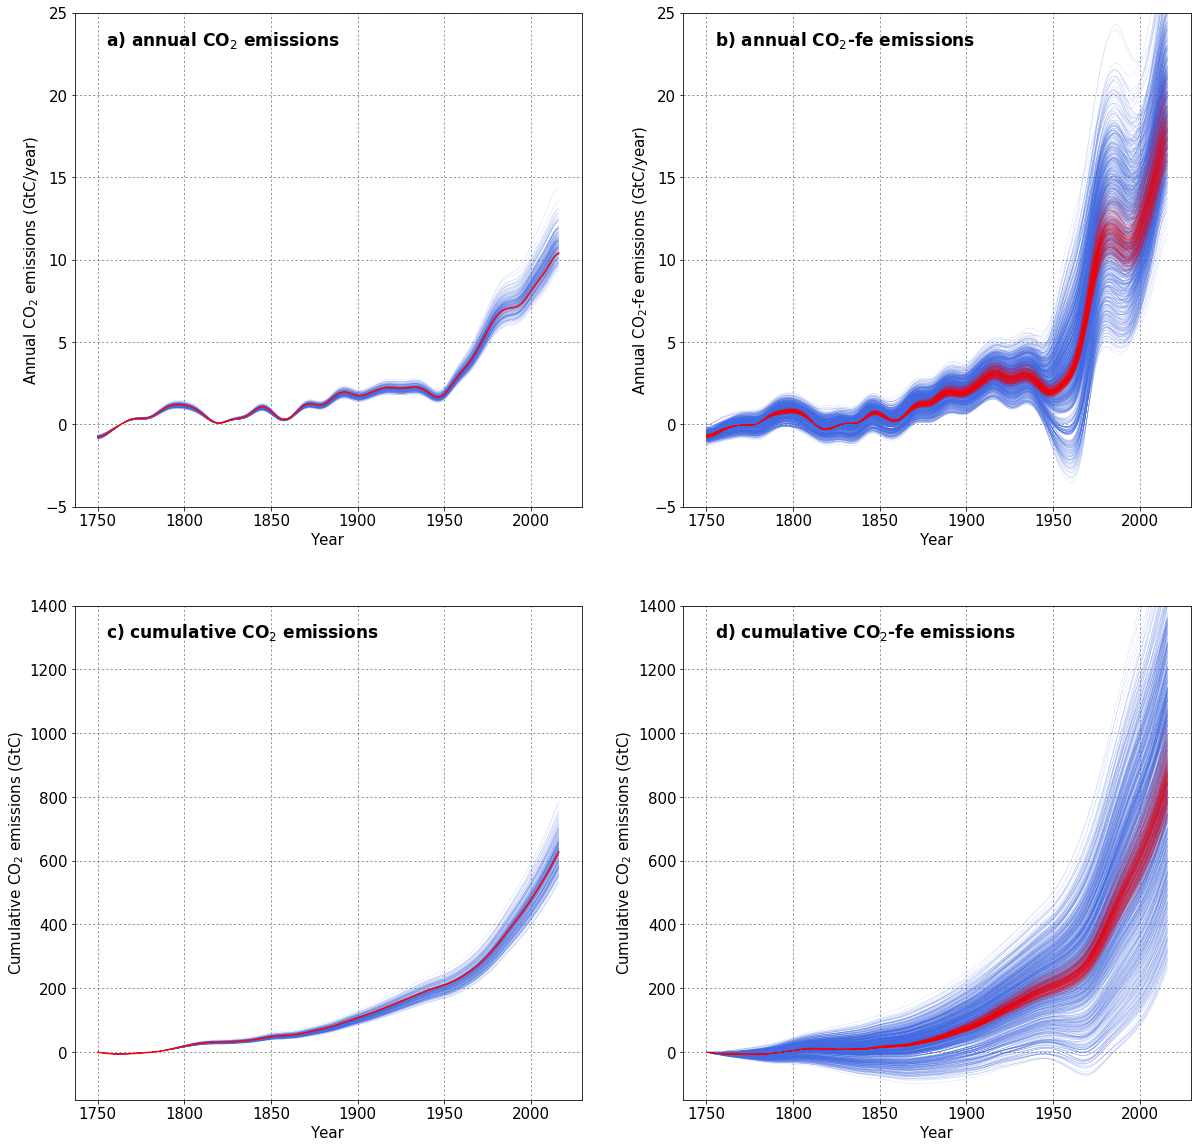

In [48]:
fig = plt.figure(figsize = (20,20))
ax3 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax1 = fig.add_subplot(222)
ax0 = fig.add_subplot(224)

for l in range(0,200):
    ax3.plot(np.arange(1750,2017), ems_smooth_params_co2[0,l,:], color = 'royalblue', linewidth = 0.1)
ax3.set_xlabel('Year')
ax3.set_ylabel('Annual CO$_2$ emissions (GtC/year)')
ax3.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax3.plot(np.arange(1750,2017), ems_smooth_params_co2_median, color = 'red', linewidth = 1.5)
ax3.set_ylim(-5,25)
ax3.text(1755,23, 'a) annual CO$_2$ emissions', fontweight = 'bold', fontsize = 17)
  
for g in range(0,200):
    ax2.plot(np.arange(1750,2017), np.cumsum(ems_smooth_params_co2[0,g,:], axis = -1), color = 'royalblue', linewidth = 0.1)
ax2.set_xlabel('Year')
ax2.set_ylabel('Cumulative CO$_2$ emissions (GtC)')
ax2.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax2.plot(np.arange(1750,2017), np.cumsum(ems_smooth_params_co2_median), color = 'red', linewidth = 1.5)
ax2.set_ylim(-150,1400)
ax2.text(1755,1300, 'c) cumulative CO$_2$ emissions', fontweight = 'bold', fontsize = 17)

for i in range(0,200):
    for j in range(0,200,40):
        ax1.plot(np.arange(1750,2017), annual_ems_array[i,j,:], color = 'royalblue', linewidth = 0.1)

for k in range(0,200):
    ax1.plot(np.arange(1750,2017), ems_smooth_params[0,k,:], color = 'red', linewidth = 0.1, alpha = 0.8)

ax1.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual CO$_2$-fe emissions (GtC/year)')
ax1.set_ylim(-5,25)
ax1.text(1755,23, 'b) annual CO$_2$-fe emissions', fontweight = 'bold', fontsize = 17)

for h in range(0,200):
    for g in range(0,200,40):
        ax0.plot(np.arange(1750,2017), np.cumsum(annual_ems_array[h,g,:], axis = -1), color = 'royalblue', linewidth = 0.1)
ax0.set_xlabel('Year')
ax0.set_ylabel('Cumulative CO$_2$ emissions (GtC)')
ax0.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
#ax0.plot(np.arange(1750,2017), np.cumsum(ems_smooth_params_co2_median), color = 'red', linewidth = 1.5)
ax0.set_ylim(-150,1400)
ax0.text(1755,1300, 'd) cumulative CO$_2$-fe emissions', fontweight = 'bold', fontsize = 17)

for f in range(0,200):
    ax0.plot(np.arange(1750,2017), np.cumsum(ems_smooth_params[0,f,:]), color = 'red', linewidth = 0.1, alpha = 0.8)
        
fig.savefig('testfig1')

In [26]:
#with file('forcing_uncertainty_test.txt', 'w') as outfile:
#    outfile.write('# Array shape: {0}\n'.format(annual_ems_array.shape))
#    for data_slice in annual_ems_array:
#        np.savetxt(outfile, data_slice, fmt='%-7.8f')
#        outfile.write('# New slice\n')

In [8]:
annual_ems_array = np.loadtxt("forcing_uncertainty_test.txt")
annual_ems_array = annual_ems_array.reshape((200,200,267))

In [47]:
hist_plots = np.cumsum(annual_ems_array, axis = -1)
hist_plots_2015_1870 = hist_plots[:,:,2015-1750] - hist_plots[:,:,1870-1750]

hist_final_cum = np.zeros(40000)
for i in range(0,200):
    hist_final_cum[(i%200)*200 + i] = hist_plots_2015_1870[(i%200)*200,i]

f = plt.hist(hist_final_cum, bins = 1000, color = 'royalblue', normed = True)    

#for i in range(0,200,2):
#    plt.hist(hist_plots_2015_1870[i,:], bins = 100, alpha = 0.1, color = 'royalblue')

IndexError: index 200 is out of bounds for axis 0 with size 200